## Capstone Project

In [1]:
# install packages
# coding: utf-8
!pip install unidecode

In [2]:
# download corpus of stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yumengli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# import modules
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as ss
import unidecode
from nltk.corpus import stopwords
from scipy.special import inv_boxcox
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
# load the data
data = pd.read_csv("pet food data.csv")

There are 684 entries that do not have price data, 548 entries that do not have an ingredients list, 755 entries that do not have a total package size, and 747 entries that do not have a unit package size.

In [5]:
# get a description of the unprocessed data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8754 entries, 0 to 8753
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  8754 non-null   object 
 1   category              8754 non-null   object 
 2   sub_category          8754 non-null   object 
 3   product               8754 non-null   object 
 4   variant               8754 non-null   object 
 5   description           8754 non-null   object 
 6   ingredients_stdlist   8206 non-null   object 
 7   price_usd             8070 non-null   float64
 8   company_parent        8754 non-null   object 
 9   company               8754 non-null   object 
 10  brand                 8754 non-null   object 
 11  total_pack_size_ml_g  7999 non-null   float64
 12  unit_pack_size_ml_g   8007 non-null   float64
dtypes: float64(3), object(10)
memory usage: 889.2+ KB


In [6]:
# determine if there are any duplicate rows
np.sum(data.duplicated())

0

In [7]:
data.company.unique

<bound method Series.unique of 0                         Mars
1         Big Heart Pet Brands
2                         Iams
3                         Iams
4       Del Monte Pet Products
                 ...          
8749                    Target
8750     Nestlé Purina PetCare
8751      Big Heart Pet Brands
8752     Nestlé Purina PetCare
8753      Big Heart Pet Brands
Name: company, Length: 8754, dtype: object>

### Initial Cleaning for Visualization

In [8]:
# drop all of the NaN entries
data.dropna(inplace=True)

# remove 1 outlier price with invalid pack size
data = data[data.price_usd < 50]

# remove 1 unit pack size equal to 0
data = data[data.unit_pack_size_ml_g > 0]

# drop 32 therapeutic supplements 
data = data.loc[~data.ingredients_stdlist.str.startswith("active"), :]

# reset the index
data.reset_index(drop=True, inplace=True)

In [9]:
# transform the string dates into datetime objects and create a year column
data.loc[:, "date"] = pd.to_datetime(data.date.str[:10])
data["year"] = data.date.apply(lambda x: x.year)

In [10]:
# drop the "category" column since it contains one value "Pet Food" and
# the "variant" column since it is equivalent to the "product" column
data.drop(columns=["category", "product"], inplace=True)

In [11]:
# add a ratio column of pack sizes to the dataframe
data["ratio"] = data.total_pack_size_ml_g / data.unit_pack_size_ml_g

In [12]:
# transform the "sub_category" column into separate columns and drop "sub_category"
data["pet_type"] = data.sub_category.apply(lambda x: "cat" if ("Cat" in x) else "dog")
data["meal_type"] = data.sub_category.apply(lambda x: "primary" if ("Food" in x) else "treats")
data["food_type"] = data.sub_category.apply(lambda x: "dry" if ("Dry" in x) else "wet")
data.drop(columns="sub_category", inplace=True)

In [13]:
# create a function to replace dicritic characters with ASCII characters
def replace_dicritic(string):
    return unidecode.unidecode(string)

In [14]:
# replace the dicritic characters in "company_parent", "company", "brand",
# "description", and "ingredients_stdlist"
data.loc[:, "company_parent"] = data.company_parent.apply(replace_dicritic)
data.loc[:, "company"] = data.company.apply(replace_dicritic)
data.loc[:, "brand"] = data.brand.apply(replace_dicritic)
data.loc[:, "description"] = data.description.apply(replace_dicritic)
data.loc[:, "ingredients_stdlist"] = data.ingredients_stdlist.apply(replace_dicritic)

In [15]:
# get a description of the cleaned data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7525 entries, 0 to 7524
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  7525 non-null   datetime64[ns]
 1   variant               7525 non-null   object        
 2   description           7525 non-null   object        
 3   ingredients_stdlist   7525 non-null   object        
 4   price_usd             7525 non-null   float64       
 5   company_parent        7525 non-null   object        
 6   company               7525 non-null   object        
 7   brand                 7525 non-null   object        
 8   total_pack_size_ml_g  7525 non-null   float64       
 9   unit_pack_size_ml_g   7525 non-null   float64       
 10  year                  7525 non-null   int64         
 11  ratio                 7525 non-null   float64       
 12  pet_type              7525 non-null   object        
 13  meal_type         

### Visualizations

In [16]:
# get the observations for Colgate only
colgate_only = data[data.company_parent.apply(lambda x: "colgate" in x.lower())]

In [17]:
# perform a Box-Cox transformation on price_usd
box_cox = ss.boxcox(data.price_usd)

Boxplots

In [18]:
# boxplot for cat vs dog
fig1 = px.box(data, x="pet_type", y="price_usd")
fig2 = px.box(colgate_only, x="pet_type", y="price_usd", category_orders={"pet_type": ["cat", "dog"]})

# boxplot for primary food vs treats
fig3 = px.box(data, x="meal_type", y="price_usd")
fig4 = px.box(colgate_only, x="meal_type", y="price_usd")

# boxplot for dry vs wet food
fig5 = px.box(data, x="food_type", y="price_usd")
fig6 = px.box(colgate_only, x="food_type", y="price_usd", category_orders={"food_type": ["dry", "wet"]})

# boxplot for year
fig7 = px.box(data, x="year", y="price_usd")

Histograms

In [19]:
# histogram of price
fig8 = px.histogram(data.price_usd)

# histogram of price with Box-Cox transformation
fig9 = px.histogram(box_cox[0], nbins=50)

Scatter Plots

In [20]:
# scatter plot of price vs unit pack size
fig10 = px.scatter(data.loc[~data.unit_pack_size_ml_g.isna(), :], x="unit_pack_size_ml_g", y="price_usd", trendline="ols", trendline_color_override="orange", range_y=[-2, 37])

### Text Transformations

In [21]:
# get the first word in every ingredient list
first_ingredient = data.ingredients_stdlist.str.split(",").apply(lambda x: x[0])
first_ingredient = first_ingredient.str.split(" ").apply(lambda x: x[0])
first_ingredient = first_ingredient.str.split(":").apply(lambda x: x[0].lower())

In [22]:
# look at the top 10 words by frequency count
first_ingredient.value_counts()[:10]

chicken    1871
wheat       675
beef        568
corn        412
water       350
turkey      289
salmon      249
lamb        225
rice        203
duck        115
Name: ingredients_stdlist, dtype: int64

In [23]:
# create a function that filters the first_ingredient Series to
# 5 possible words
def first_word(string):
    if string == "chicken" or string == "wheat" or string == "beef" or string == "corn":
        return string
    else:
        return "other"

In [24]:
# add a first_ingredient column to the dataset
data["first_ingredient"] =  first_ingredient.apply(first_word)

TFIDF

During testing, we discovered that using a TFIDF matrix with more than ~400 features in our regression models caused instability, resulting in errors that were $10^6$ or greater. To improve performance, we set max_features=400 in our TfidfVectorizer().

In [25]:
# instantiate the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), max_features=400)

# transform the product descriptions in a TFIDF matrix
vectors = vectorizer.fit_transform(data.description)

# convert the TFIDF matrix into a dataframe
tfidf = pd.DataFrame(vectors.todense().tolist(), columns=vectorizer.get_feature_names())

# manually remove any remaining stop words
tfidf.drop(columns=["10", "100", "12", "13", "14", "15", "16", "20", "24", "25", "50", "also", "lb", "lbs", "oz"], inplace=True)

Convert categorical variables to one-hot vectors

In [26]:
# get all of the categorical variables in one dataframe
cat_vars = data[["pet_type", "meal_type", "food_type", "first_ingredient"]]

# transform the categorical variables into one-hot vectors
one_hot = pd.get_dummies(cat_vars, prefix="category")

### Combine all of the engineered features and create training and testing sets

In [27]:
# gather all of the pack size columns
sizes = data[["total_pack_size_ml_g", "unit_pack_size_ml_g", "ratio"]]
sizes

,total_pack_size_ml_g,unit_pack_size_ml_g,ratio
0,3175.20,3175.20,1.0
1,10886.40,10886.40,1.0
2,4445.28,4445.28,1.0
3,4898.88,4898.88,1.0
4,6123.60,6123.60,1.0
...,...,...,...
7520,708.75,708.75,1.0
7521,708.75,708.75,1.0
7522,708.75,708.75,1.0
7523,708.75,708.75,1.0


In [28]:
# combine the 1hot dataframe with the TFIDF dataframe
X = pd.concat([one_hot, sizes, tfidf], axis=1)

# create a target variable for the Box-Cox transformed prices
y = box_cox[0]

In [29]:
X.shape, y.shape

((7525, 399), (7525,))

### Predictive Price Modeling

Optimal Model Implementation

In [30]:
# standardize the dataset
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std.shape

(7525, 399)

In [31]:
# instantiate a LASSO regressor with optimal hyperparameters
lasso_reg = Lasso(alpha=0.006428)

# train the LASSO regressor on the full dataset
lasso_reg.fit(X_std, y)

Lasso(alpha=0.006428)

In [32]:
# get the predicted prices
pred = lasso_reg.predict(X_std)

# reverse the box-cox transformation to get the predicted prices in dollars
pred_usd = inv_boxcox(pred, box_cox[1])

Visualizations

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
# put the coefficients in a Series with their respective names
coef = pd.Series(lasso_reg.coef_, index=X.columns.values)

# sort the values in place, descending
coef.sort_values(ascending=False, inplace=True)

# get the top 20 and bottom 20
top20_bottom20 = pd.concat([coef[:20], coef[-20:]])

/Users/yumengli/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



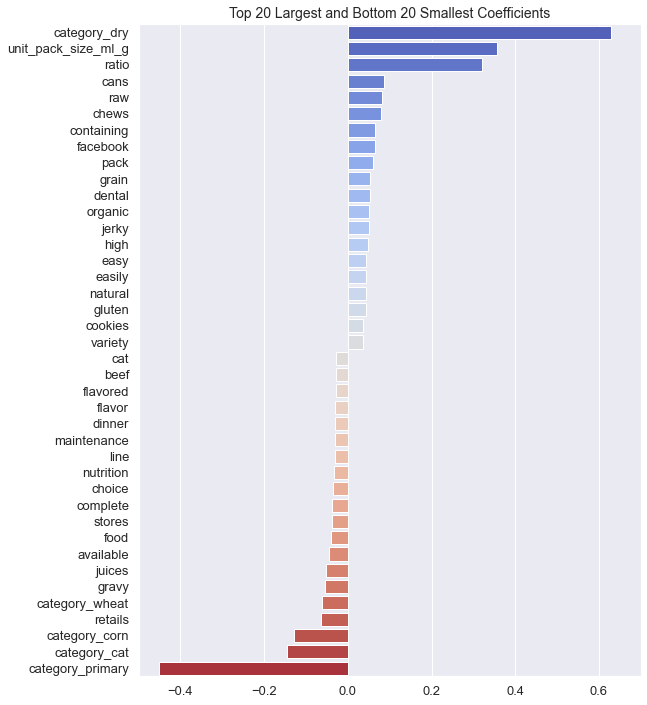

In [35]:
plt.figure(figsize=(9, 12))
sns.barplot(top20_bottom20.values, top20_bottom20.index.values,
            orient="h", palette='coolwarm')
plt.xlim(-0.5, 0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Top 20 Largest and Bottom 20 Smallest Coefficients", fontsize=14);

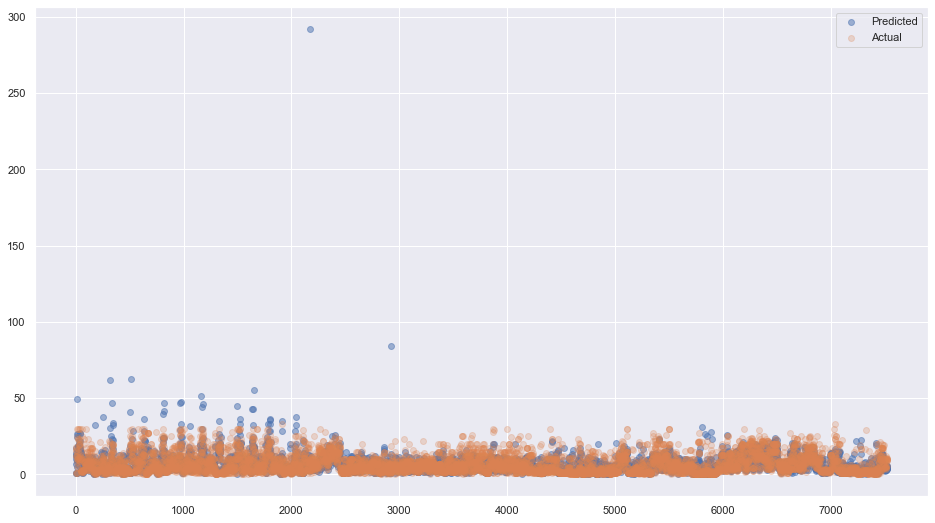

In [36]:
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(0, 7525), pred_usd, alpha=0.5, label="Predicted")
plt.scatter(np.arange(0, 7525), data.price_usd, alpha=0.25, label="Actual")
plt.legend();

## Grouping  Models

### PCA Analysis

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_std)
PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)

In [38]:
principalDF = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'] )
principalDF

,principal component 1,principal component 2
0,9.536697,-2.036845
1,5.588050,-0.481355
2,6.753276,-1.275136
3,8.292280,-1.737183
4,7.256044,-0.239073
...,...,...
7520,-3.876338,-1.126930
7521,-3.349665,-0.584679
7522,-3.701506,-0.417857
7523,-3.714606,-1.497934


PCA for meal type

In [39]:
finalDF_mealType = pd.concat([principalDF, data[["meal_type"]]], axis = 1)
finalDF_mealType

,principal component 1,principal component 2,meal_type
0,9.536697,-2.036845,primary
1,5.588050,-0.481355,primary
2,6.753276,-1.275136,primary
3,8.292280,-1.737183,primary
4,7.256044,-0.239073,primary
...,...,...,...
7520,-3.876338,-1.126930,treats
7521,-3.349665,-0.584679,treats
7522,-3.701506,-0.417857,treats
7523,-3.714606,-1.497934,treats


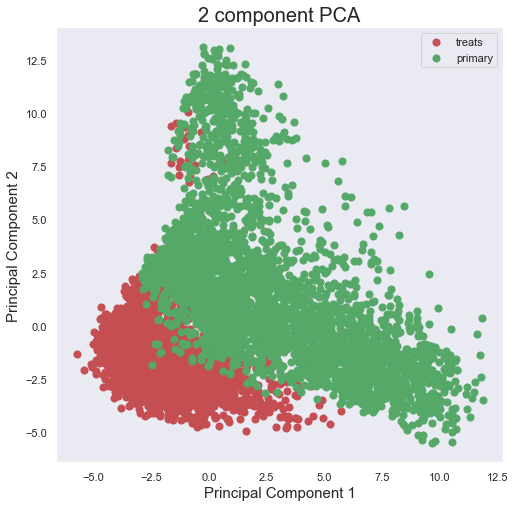

In [40]:
# visualizing PCA
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["treats", "primary"]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indx = finalDF_mealType['meal_type'] == target
    ax.scatter(finalDF_mealType.loc[indx, 'principal component 1'],
              finalDF_mealType.loc[indx, 'principal component 2'],
             c = color, s = 50)
ax.legend(targets)
ax.grid()

PCA for foodtype

In [41]:
finalDF_foodType = pd.concat([principalDF, data[["food_type"]]], axis = 1)
finalDF_foodType

,principal component 1,principal component 2,food_type
0,9.536697,-2.036845,dry
1,5.588050,-0.481355,dry
2,6.753276,-1.275136,dry
3,8.292280,-1.737183,dry
4,7.256044,-0.239073,dry
...,...,...,...
7520,-3.876338,-1.126930,wet
7521,-3.349665,-0.584679,wet
7522,-3.701506,-0.417857,wet
7523,-3.714606,-1.497934,wet


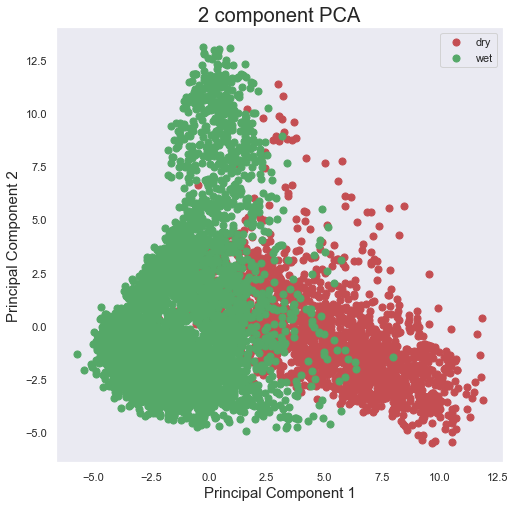

In [42]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["dry", "wet"]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indx = finalDF_foodType['food_type'] == target
    ax.scatter(finalDF_foodType.loc[indx, 'principal component 1'],
              finalDF_foodType.loc[indx, 'principal component 2'],
             c = color, s = 50)
ax.legend(targets)
ax.grid()

### Doc2Vec Analysis Using Cosine Similarity 
#### this shows how similar a new description document is to the other existing documents

In [43]:
import multiprocessing
multiprocessing.cpu_count()

4

In [44]:
import gensim
import smart_open
## Using Gensim package reading in the corpus
def read_corpus(set):       
    for i, line in enumerate(set):
        tokens = gensim.utils.simple_preprocess(line)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
corpus = list(read_corpus(data.description))

In [45]:
# Building the doc to vec model 
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(corpus)

In [46]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [47]:
# Pick a random document from the corpus and infer a vector from the model
String ='Tibbles & Bits brand organic dog food is naturally gluten and grain-free, and provides your pet with the best variety of raw ingredients. Follow us on Facebook to see all of our cookies, chews, and jerky.'
tokens = gensim.utils.simple_preprocess(String)
inferred_vector = model.infer_vector(tokens)
## choose the top 100 most similar documents with biggest to smallest cosine smilarity score
sims = model.docvecs.most_similar([inferred_vector], topn=100)
sims

[(1994, 0.5810853242874146),
 (2649, 0.5496307611465454),
 (3244, 0.5401643514633179),
 (7455, 0.5335648059844971),
 (5477, 0.5254746675491333),
 (6835, 0.5198439955711365),
 (603, 0.5166947841644287),
 (5073, 0.5154356956481934),
 (605, 0.4933776259422302),
 (3463, 0.49253225326538086),
 (5674, 0.4881405830383301),
 (6771, 0.4863950312137604),
 (3528, 0.4860175549983978),
 (3199, 0.4803486168384552),
 (378, 0.480010986328125),
 (3551, 0.47958260774612427),
 (57, 0.472555935382843),
 (4741, 0.464607834815979),
 (4417, 0.46265435218811035),
 (2494, 0.46187931299209595),
 (4442, 0.4586716890335083),
 (7345, 0.4571363627910614),
 (5841, 0.45441538095474243),
 (2015, 0.4499411880970001),
 (5373, 0.4493277668952942),
 (2340, 0.44792598485946655),
 (741, 0.4473320245742798),
 (7108, 0.4467415511608124),
 (437, 0.44604650139808655),
 (813, 0.4455583393573761),
 (3881, 0.4455180764198303),
 (6474, 0.44366270303726196),
 (2875, 0.4423545002937317),
 (3527, 0.4420429468154907),
 (1466, 0.4404442

In [48]:
# get the index of the most similar documents from the tuple sims object
# first is index second is cosine similarity score
inds=[i[0] for i in sims]
# create a new dataframe with these new index of top 100 most similar documents
data_new = data.loc[inds]
data_new.head()

,date,variant,description,ingredients_stdlist,price_usd,company_parent,company,brand,total_pack_size_ml_g,unit_pack_size_ml_g,year,ratio,pet_type,meal_type,food_type,first_ingredient
1994,2008-09-25,Turkey & Chicken Formula,Newman's Own Organics Dog Food Range is compri...,"Turkey & Chicken Formula:\nChicken Meat, Barle...",1.99,Newman's Own,Newman's Own Organics,Newman's Own Organics,360.05,360.05,2008,1.0,dog,primary,wet,other
2649,2010-04-21,Duck Treats for Dogs,Stella & Chewy's Carnivore Crunch has introduc...,"Duck Meat (Ground) (Bone), Goose Meat, Turkey ...",12.00,Stella & Chewy's,Stella & Chewy's,Stella & Chewy's Carnivore Crunch,113.40,113.40,2010,1.0,dog,treats,wet,other
3244,2018-11-08,Chicken and Peanut Butter Flavored All Natural...,Look Who's Happy Snack'ems Chicken and Peanut ...,"Chicken Meat, Glycerol (Coconut Derived), Pean...",11.99,Big Creek Foods,Big Creek Foods,Look Who's Happy Snack'ems,226.80,226.80,2018,1.0,dog,treats,wet,chicken
7455,2019-09-26,Grin for Dental Health Soft Chews for Dogs,InClover Research Grin for Dental Health Soft ...,"Potato Flour, Pea Flour (Powdered), Glycerol, ...",20.99,In Clover,In Clover,InClover Research,425.25,425.25,2019,1.0,dog,treats,wet,other
5477,2012-04-20,Chicken Heart Shaped Patties,Stewart Raw Naturals Fresh to Home Chicken Hea...,"Chicken Meat, Chicken Bone (Ground), Chicken L...",16.99,MiracleCorp,MiracleCorp,Stewart Raw Naturals,1360.80,1360.80,2012,1.0,dog,primary,wet,chicken


In [54]:
# get the top 5 most similar documents with the given index 
top5 = data_new[:5]
# get the top 5 most similar pet food descriptions
print(top5.description)
# get the top 5 most similar pet food company
print(top5.company)

1994    Newman's Own Organics Dog Food Range is compri...
2649    Stella & Chewy's Carnivore Crunch has introduc...
3244    Look Who's Happy Snack'ems Chicken and Peanut ...
7455    InClover Research Grin for Dental Health Soft ...
5477    Stewart Raw Naturals Fresh to Home Chicken Hea...
Name: description, dtype: object
1994    Newman's Own Organics
2649         Stella & Chewy's
3244          Big Creek Foods
7455                In Clover
5477              MiracleCorp
Name: company, dtype: object


In [50]:
# get the summary statistic of the sales price of top 10 most similar documents
data_new[:10].price_usd.describe()

count    10.000000
mean     13.106000
std       5.536927
min       1.990000
25%      10.402500
50%      11.995000
75%      17.740000
max      20.990000
Name: price_usd, dtype: float64